In [1]:
%load_ext autoreload
%autoreload 2

import argparse
from collections import OrderedDict
import datetime
import gc
get_ipython().run_line_magic('matplotlib', 'inline')
import matplotlib
import matplotlib.pylab as plt
from numbers import Number
import numpy as np
import pandas as pd
pd.options.display.max_rows = 1500
pd.options.display.max_columns = 200
pd.options.display.width = 1000
pd.set_option('max_colwidth', 400)
import pdb
import pickle
import pprint as pp
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import DataLoader
from deepsnap.batch import Batch as deepsnap_Batch
import xarray as xr
import math
import dolfin

import sys, os
sys.path.append(os.path.join(os.path.dirname("__file__"), '..'))
sys.path.append(os.path.join(os.path.dirname("__file__"), '..', '..'))
from lamp.argparser import arg_parse
# from design.fno_dataset import FNOData
from lamp.datasets.load_dataset import load_data
from lamp.models import load_model#, rollout, rollout_plasma, plot_vlasov
from lamp.pytorch_net.util import Printer, Attr_Dict, get_num_params, get_machine_name, pload, pdump, to_np_array, get_pdict, reshape_weight_to_matrix, ddeepcopy as deepcopy, plot_vectors, record_data, filter_filename, Early_Stopping, str2bool, get_filename_short, print_banner, plot_matrices, get_num_params, init_args, filter_kwargs, to_string, COLOR_LIST
# from settings.hyperparams import update_legacy_default_hyperparam
# from settings.filepath import EXP_PATH
from lamp.utils import LpLoss, to_cpu, to_tuple_shape, parse_multi_step, loss_op, get_cholesky_inverse, get_device, get_data_comb, EXP_PATH, update_legacy_default_hyperparam
# from multiscale.utilities import pyg2obj, verface2obj

device = torch.device("cuda:7")
p = Printer()

/lfs/ampere2/0/takashi279/miniconda3/envs/lamp2/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Cannot import trimesh. If do not need trimesh, can ignore this message.


/afs/cs.stanford.edu/u/takashi279/.local/lib/python3.7/site-packages/h5py/__init__.py:39: UserWarning: h5py is running against HDF5 1.12.2 when it was built against 1.12.1, this may cause problems
  '{0}.{1}.{2}'.format(*version.hdf5_built_version_tuple)


## Functions

In [5]:
# Plotting:
def plot_learning_curve(data_record):
    plt.figure(figsize=(16,6))
    plt.subplot(1,2,1)
    plt.plot(data_record["epoch"], data_record["train_loss"], label="train")
    plt.plot(data_record["test_epoch"] if "test_epoch" in data_record else data_record["epoch"], data_record["val_loss"], label="val")
    plt.plot(data_record["test_epoch"] if "test_epoch" in data_record else data_record["epoch"], data_record["test_loss"], label="test")
    plt.title("Learning curve, linear scale")
    plt.legend()
    plt.subplot(1,2,2)
    plt.semilogy(data_record["epoch"], data_record["train_loss"], label="train")
    plt.semilogy(data_record["test_epoch"] if "test_epoch" in data_record else data_record["epoch"], data_record["val_loss"], label="val")
    plt.semilogy(data_record["test_epoch"] if "test_epoch" in data_record else data_record["epoch"], data_record["test_loss"], label="test")
    plt.title("Learning curve, log scale")
    plt.legend()
    plt.show()


def plot_colorbar(matrix, vmax=None, vmin=None, cmap="seismic", label=None):
    if vmax==None:
        vmax = matrix.max()
        vmin = matrix.min()
    im = plt.imshow(matrix,vmax=vmax,vmin=vmin,cmap=cmap)
    plt.title(label)
    im_ratio = matrix.shape[0]/matrix.shape[1]
    plt.colorbar(im,fraction=0.046*im_ratio,pad=0.04)


def visualize(pred, gt, animate=False):
    if torch.is_tensor(gt):
        gt = to_np_array(gt)
        pred = to_np_array(pred)
    mse_over_t = ((gt-pred)**2).mean(axis=0).mean(axis=-1)
     
    if not animate:
        vmax = gt.max()
        vmin = gt.min()
        plt.figure(figsize=[15,5])
        plt.subplot(1,4,1)
        plot_colorbar(gt[:,:,0].T,label="gt")
        plt.subplot(1,4,2)
        plot_colorbar(pred[:,:,0].T,label="pred")
        plt.subplot(1,4,3)
        plot_colorbar((pred-gt)[:,:,0].T,vmax=np.abs(pred-gt).max(),vmin=(-1*np.abs(pred-gt).max()),label="diff")
        plt.subplot(1,4,4)
        plt.plot(mse_over_t);plt.title("mse over t");plt.yscale('log');
        plt.tight_layout()
        plt.show()

def visualize_paper(pred, gt, is_save=False):
    idx = 6
    nx = pred.shape[0]

    fontsize = 14
    idx_list = np.arange(0, 200, 15)
    color_list = np.linspace(0.01, 0.9, len(idx_list))
    x_axis = np.linspace(0,16,nx)
    cmap = matplotlib.cm.get_cmap('jet')

    plt.figure(figsize=(16,5))
    plt.subplot(1,2,1)
    for i, idx in enumerate(idx_list):
        pred_i = to_np_array(pred[...,idx,:].squeeze())
        rgb = cmap(color_list[i])[:3]
        plt.plot(x_axis, pred_i, color=rgb, label=f"t={np.round(i*0.3, 1)}s")
    plt.ylabel("u(t,x)", fontsize=fontsize)
    plt.xlabel("x", fontsize=fontsize)
    plt.tick_params(labelsize=fontsize)
    # plt.legend(fontsize=10, bbox_to_anchor=[1,1])
    plt.xticks([0,8,16], [0,8,16])
    plt.ylim([-2.5,2.5])
    plt.title("Prediction")
    if is_save:
        plt.savefig(f"1D_E2-{nx}.pdf", bbox_inches='tight')

    plt.subplot(1,2,2)
    for i, idx in enumerate(idx_list):
        y_i = to_np_array(gt[...,idx,:])
        rgb = cmap(color_list[i])[:3]
        plt.plot(x_axis, y_i, color=rgb, label=f"t={np.round(i*0.3, 1)}s")
    plt.ylabel("u(t,x)", fontsize=fontsize)
    plt.xlabel("x", fontsize=fontsize)
    plt.tick_params(labelsize=fontsize)
    plt.legend(fontsize=10, bbox_to_anchor=[1,1])
    plt.xticks([0,8,16], [0,8,16])
    plt.ylim([-2.5,2.5])
    plt.title("Ground-truth")
    if is_save:
        plt.savefig(f"1D_gt-{nx}.pdf", bbox_inches='tight')
    plt.show()
    
def yield_f_file(path, filename):
    """ Generate data of faces.
    Args:
        path: path to the folder in which folder is.
        filename: name of the obj filename.

    Returns:
        list of faces.        
    """
    f = open(os.path.join(path, filename))
    buf = f.read()
    f.close()
    for b in buf.split('\n'):
        if b.startswith('f '):
            triangles = b.split(' ')[1:]
            # -1 as .obj is base 1 but the Data class expects base 0 indices
            yield [int(t.split("/")[0]) - 1 for t in triangles]
            
def gen_v_file(path, filename):
    """ Generate data of vertices.
    Args:
        path: path to the folder in which folder is.
        filename: name of the obj filename.

    Returns:
        list of vertices. Each vertex is represented by 3d vector.       
    """
    f = open(os.path.join(path, filename))
    buf = f.read()
    f.close()
    nodes = []
    for b in buf.split('\n'):
        if b.startswith('v '):
            nodes.append([float(x) for x in b.split(" ")[1:]])
    return np.array(nodes)

from matplotlib.backends.backend_pdf import PdfPages

def to_device_recur(iterable, device, is_detach=False):
    if isinstance(iterable, list):
        return [to_device_recur(item, device, is_detach=is_detach) for item in iterable]
    elif isinstance(iterable, tuple):
        return tuple(to_device_recur(item, device, is_detach=is_detach) for item in iterable)
    elif isinstance(iterable, dict):
        Dict = {key: to_device_recur(item, device, is_detach=is_detach) for key, item in iterable.items()}
        if iterable.__class__.__name__ == "Pdict":
            from pstar import pdict
            class Pdict(pdict):
                def to(self, device):
                    self["device"] = device
                    return to_device_recur(self, device)

                def copy(self):
                    return Pdict(dict.copy(self))
            Dict = Pdict(Dict)
        elif iterable.__class__.__name__ == "Attr_Dict":
            Dict = Attr_Dict(Dict)
        return Dict
    elif hasattr(iterable, "to"):
        iterable = iterable.to(device)
        if is_detach:
            iterable = iterable.detach()
        return iterable
    else:
        if hasattr(iterable, "detach"):
            iterable = iterable.detach()
        return iterable

def pyg_to_dolfin_mesh(vers, faces):
    mesh = dolfin.Mesh()
    editor = dolfin.MeshEditor()
    editor.open(mesh, 'triangle', 2, 2)

    editor.init_vertices(vers.shape[0])
    for i in range(vers.shape[0]):
        editor.add_vertex(i, vers[i,:2])
    editor.init_cells(faces.shape[0])
    for f in range(faces.shape[0]):
        editor.add_cell(f, faces[f])

    editor.close()
    return mesh

def generate_baryweight(tarvers, mesh, bvh_tree):
    faces = []
    weights = []
    for query in tarvers:
        face = bvh_tree.compute_first_entity_collision(dolfin.Point(query))
        while (mesh.num_cells() <= face):
            #print("query: ", query)
            if query[0] < 0.5:
                query[0] += 1e-15
            elif query[0] >= 0.5:
                query[0] -= 1e-15
            if query[1] < 0.5:
                query[1] += 1e-15
            elif query[1] >= 0.5:
                query[1] -= 1e-15            
            face = bvh_tree.compute_first_entity_collision(dolfin.Point(query))
        faces.append(face)
        face_coords = mesh.coordinates()[mesh.cells()[face]]
        mat = face_coords.T[:,[0,1]] - face_coords.T[:,[2,2]]
        const = query - face_coords[2,:]
        weight = np.linalg.solve(mat, const)
        final_weights = np.concatenate([weight, np.ones(1) - weight.sum()], axis=-1)
        weights.append(final_weights)
    return faces, weights

def generate_barycentric_interpolated_data(mesh, bvhtree, outvec, tarvers):
    faces, weights = generate_baryweight(tarvers, mesh, bvhtree)
    indices = mesh.cells()[faces].astype('int64')
    fweights = torch.tensor(np.array(weights), dtype=torch.float32)
    return torch.matmul(fweights, torch.tensor(outvec[indices,:], dtype=torch.float32)).diagonal().T
    
# Analysis:
def get_results_2d(all_hash, mode="best", dirname=None, suffix=""):
    """
    Perform analysis on the 1D Burgers' benchmark.

    Args:
        all_hash: a list of hashes which indicates the experiments to load for analysis
        mode: choose from "best" (load the best model with lowest validation loss) or an integer, 
            e.g. -1 (last saved model), -2 (second last saved model)
        dirname: if not None, will use the dirnaem provided. E.g. tailin-1d_2022-7-27
        suffix: suffix for saving the analysis result.
    """
    if not dirname.endswith("/"):
        dirname += "/"
    all_dict = {}
    isplot = True
    for hash_str in all_hash:
        # Load model:
        filename = filter_filename(dirname, include=hash_str)
        try:
            data_record = pload(dirname + filename[0])
        except Exception as e:
            print(f"error {e} in hash_str {hash_str}")
            continue
        p.print(f"Hash {hash_str}, best model at epoch {data_record['best_epoch']}:", banner_size=160)
        if isplot:
            plot_learning_curve(data_record)
        args = init_args(update_legacy_default_hyperparam(data_record["args"]))
        args.filename = filename
        data_record['best_model_dict']['type'] = 'GNNRemesherPolicy'
        # data_record['best_model_dict']['edge_threshold'] = 0.
        data_record['best_model_dict']['noise_amp'] = 0.
        data_record['best_model_dict']["correction_rate"] = 0.
        data_record['best_model_dict']["batch_size"] = 16
        if mode == "best":
            model = load_model(data_record["best_model_dict"], device=device)
            print("Load the model with best validation loss.")
        else:
            assert isinstance(mode, int)
            print(f'Load the model at epoch {data_record["epoch"][mode]}')
            model = load_model(data_record["model_dict"][mode], device=device)
        model.eval()

        # Load test dataset:
        args_test = deepcopy(args)
        #multi_step = (326 - 121) // args_test.temporal_bundle_steps
        multi_step = 125
        # multi_step = 250
        args_test.multi_step = f"1^{multi_step}"
        args_test.is_test_only = True
        args_test.is_shifted_data = True
        args_test.use_fineres_data=True
        args_test.is_1d_periodic=False
        args_test.is_normalize_pos=False
        n_test_traj = 50

        (dataset_train_val, dataset_test), (train_loader, val_loader, test_loader) = load_data(args_test)

        loss_list = []
        pred_list = []
        predl2_list = []
        y_list = []
        time_stamps_effective = len(dataset_test) // n_test_traj
        kwargs = {}
        # input_margin = 40
        input_margin = 0
        total_instances = 0
        spatial_loss = []
        for i in range(0,n_test_traj):
            idx = i * time_stamps_effective + input_margin
            data = dataset_test[idx]
            data.batch_history = {"n0": torch.empty([1], device=device)}
            data = data.to(device)
            _, info = model.interpolation_hist_forward(
                data,
                pred_steps=multi_step-2*input_margin-1,
                train=False,
                use_pos=False,
                **kwargs
            )            
            preds = [p.detach().cpu() for p in info["data_x"]]
            faces = [f.detach().cpu().numpy().T for f in info["data_face"]]
            ylabels = [y.detach().cpu().numpy() for y in list(info["data"][0].yfeatures)]
            info["data"][-1].x = info["final_gnnout"].detach().cpu()
            info["data"][-1].xfaces = torch.tensor(info["data"][-1].yface_list[multi_step-2*input_margin-1-2]).T
            temp_loss_list = []
            temp_spatial_loss = []
            temp_lossl2_list = []
            for j in range(len(info["data_x"])):
                bary_coords = preds[j].numpy()
                bary_faces = faces[j]
                targets = ylabels[j+1][:,:2]
                mesh = pyg_to_dolfin_mesh(bary_coords[:,:2], bary_faces)
                bvhtree = mesh.bounding_box_tree() 
                interp_nodes = generate_barycentric_interpolated_data(mesh, bvhtree, bary_coords, targets)
                tlossl2 = ((interp_nodes[:,3:] - torch.tensor(ylabels[j+1][:,3:]))**2).sum(dim=-1).sqrt().sum()/ylabels[j+1].shape[0]
                tloss = (nn.MSELoss(reduction="sum")(interp_nodes[:,3:], torch.tensor(ylabels[j+1][:,3:], dtype=torch.float32))/ylabels[j+1].shape[0])# .detach().cpu()
                temp_loss_list.append(tloss)
                temp_lossl2_list.append(tlossl2)
                spaceloss = (nn.MSELoss(reduction="sum")(interp_nodes[:,3:], torch.tensor(ylabels[j+1][:,3:], dtype=torch.float32))) #/preds[j].shape[0])
                temp_spatial_loss.append(spaceloss)
                total_instances += info["data_x"][j].shape[0]
            loss_list.append(sum(temp_loss_list).item())
            spatial_loss.append(sum(temp_spatial_loss).item())
            pred_list.append(temp_loss_list)
            predl2_list.append(temp_lossl2_list)
            
            # break
        loss_mean = np.mean(loss_list)
        space_rmse = math.sqrt(sum(spatial_loss)/total_instances)
        all_dict[hash_str] = (data_record['best_epoch'], loss_mean, len(data_record["train_loss"]), args.epochs)
        print(all_dict[hash_str])
        print("Rollout RMSE over all spatial coordinates, all mesh nodes, all time step, and all trajecoties for {} is {:.6e}".format(hash_str, space_rmse))
        print("Test for {} is: {:.6e} at epoch {}".format(hash_str, loss_mean, data_record['best_epoch']))

        mse_full = torch.tensor(pred_list) # nn.MSELoss(reduction="none")(pred_list, y_list)
        mse_time = to_np_array(mse_full.mean((0), True))[0,:]
        p.print("Learning curve:", is_datetime=False, banner_size=100)
        plt.figure(figsize=(12,5))
        plt.subplot(1,2,1)
        plt.plot(mse_time)
        plt.xlabel("rollout step")
        plt.ylabel("MSE")
        plt.title("MSE vs. rollout step (linear scale)")
        plt.subplot(1,2,2)
        plt.semilogy(mse_time)
        plt.xlabel("rollout step")
        plt.ylabel("MSE")
        plt.title("MSE vs. rollout step (log scale)")
        plt.show()
        plt.figure(figsize=(6,5))
        plt.plot(mse_time.cumsum())
        plt.title("cumulative MSE vs. rollout step")
        plt.xlabel("rollout step")
        plt.ylabel("cumulative MSE")
        plt.show()
        
        #break

    pdump(all_dict, f"all_dict_1d{suffix}.p")
    return info, [y.detach().cpu().numpy() for y in list(info["data"][0].y_tar)]

In [6]:
# 2023-02-18
is_visualization = False
dirname = EXP_PATH + "evo-2d_2023-02-18"
new_hash = [
    "jNdZioUu_ampere2",
]

[2023-02-19 13:41:30] Hash jNdZioUu_ampere2, best model at epoch 28:


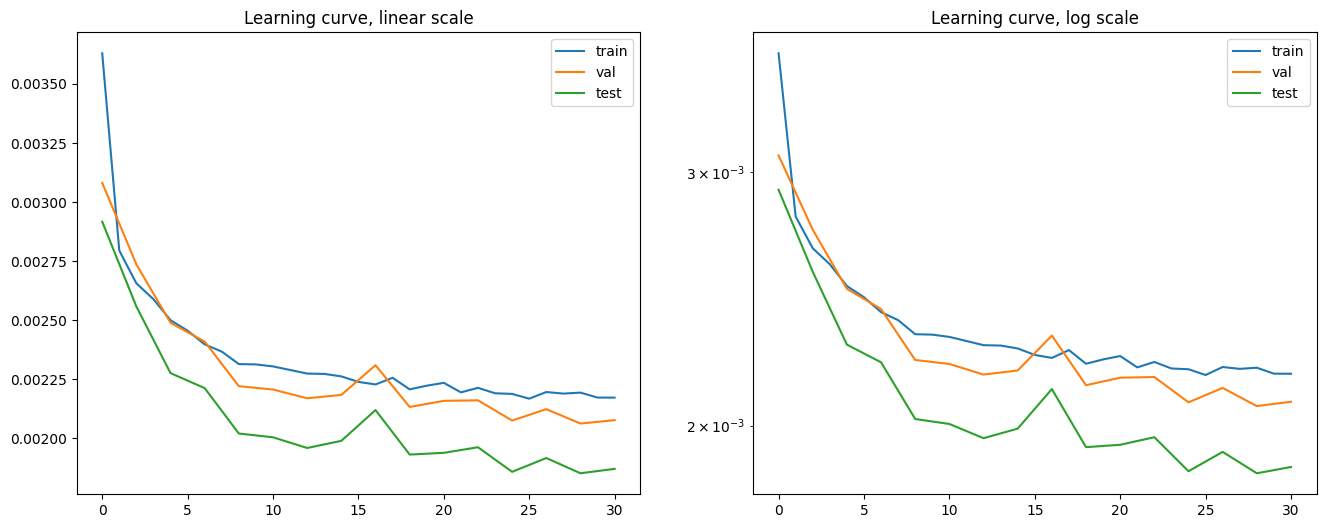

Load the model with best validation loss.
[2023-02-19 13:41:31] data/deepsnap/arcsimmesh_square_annotated_test_in_2_out_125_itv_2_normpos_False.p does not exist. Generating...
root:  data/arcsimmesh_data/
Processing...
Done!
[2023-02-19 13:41:31] :
[2023-02-19 13:41:31] saved generated deepsnap dataset to data/deepsnap/arcsimmesh_square_annotated_test_in_2_out_125_itv_2_normpos_False.p
(28, 0.7703059276938439, 31, 100)
Rollout RMSE over all spatial coordinates, all mesh nodes, all time step, and all trajecoties for jNdZioUu_ampere2 is 8.768454e-02
Test for jNdZioUu_ampere2 is: 7.703059e-01 at epoch 28
Learning curve:


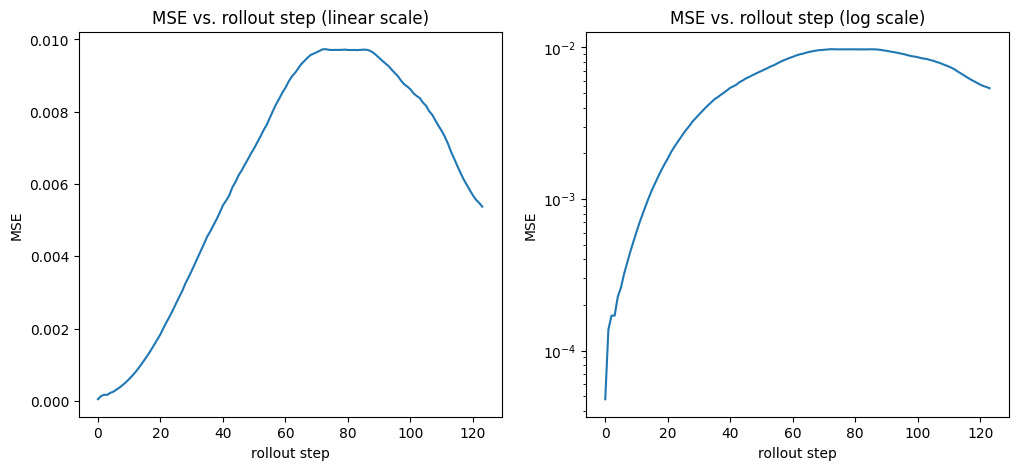

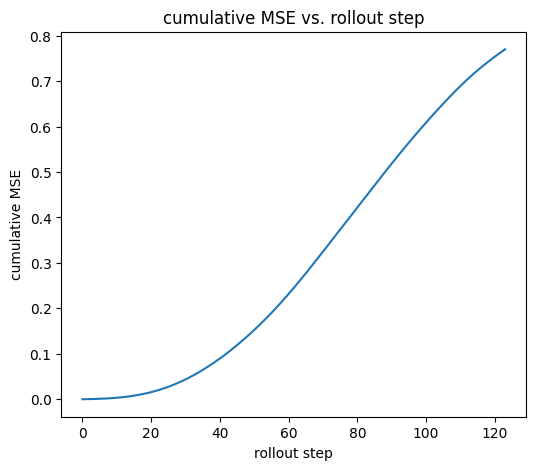

In [7]:
for nhash in new_hash:
    info, ylabels = get_results_2d([nhash], dirname=dirname)
    hashstr = nhash